In [32]:
%matplotlib inline

import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sky_spot.utils import ClusterType

api = wandb.Api()
plt.rc('font', size=16)

In [33]:
entity, project = "michaelvll", "sky-spot"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 

TAGS = ['baseline']
DDLS = {20, 20.8, 21, 23, 24}
STRATEGIES = ['strawman']

def filter_runs(tags, ddls, strategies):
    filters = {
        'env_metadata': lambda x: x['name'] == 'trace' and 'trace_file' in x and '/1.json' in x['trace_file'],
        'strategy_metadata': lambda x: x['name'] in strategies,
        'task_duration_hours': lambda x: x == 20,
        'deadline_hours': lambda x: x in ddls,
    }


    def filter_run(run):
        return all([f(run.config[k]) for k, f in filters.items()])


    run_dfs = []
    new_runs = []
    for run in runs:
        for tag in tags:
            if tag not in run.tags:
                break
        else:
            # all tags found
            df = run.history()
            df['Task/Remaining(hours)'] = df['Task/Remaining(seconds)'] / 3600
            if filter_run(run):
                run_dfs.append((run, df))
    return sorted(run_dfs, key=lambda x: x[0].config['deadline_hours'], reverse=True)

run_dfs = filter_runs(TAGS, DDLS, STRATEGIES)

In [34]:
LINE_STYLES = ['-', '--', ':', '-.', ':']
def plot_y(run_dfs, y_name='ClusterType', label_key=['deadline_hours'], label_name='ddl', is_step_plot=True):
    fig, ax = plt.subplots()
    strategy, task_duration = None, None
    for i, (run, df) in enumerate(run_dfs):
        label = run.config
        for k in label_key:
            label = label[k]
        drawstyle = 'steps-post' if is_step_plot else None
        sns.lineplot(x=df['Elapsed'] / 3600, y=df[y_name], label=f'{label_name}={label}', 
                    linestyle=LINE_STYLES[i%len(LINE_STYLES)], drawstyle=drawstyle, ax=ax)
    ax.legend(loc='best')
    return ax

## Strawman Strategy

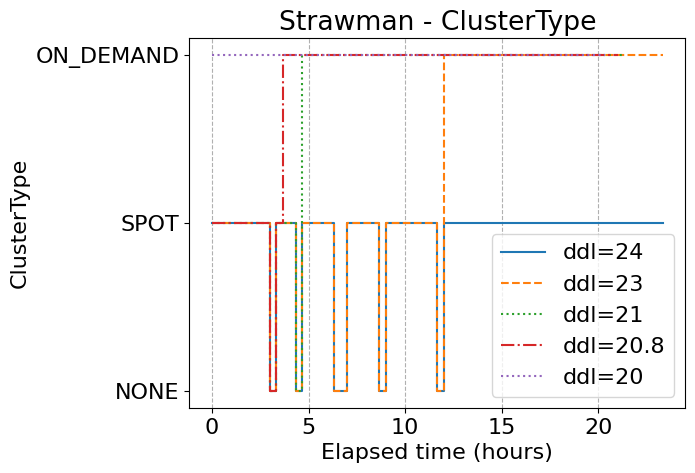

In [35]:
ax = plot_y(run_dfs, y_name='ClusterType')
ax.set_xlabel('Elapsed time (hours)')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
ax.set_title(f'Strawman - ClusterType')
ax.grid(True, which='major', axis='x', linestyle='--')

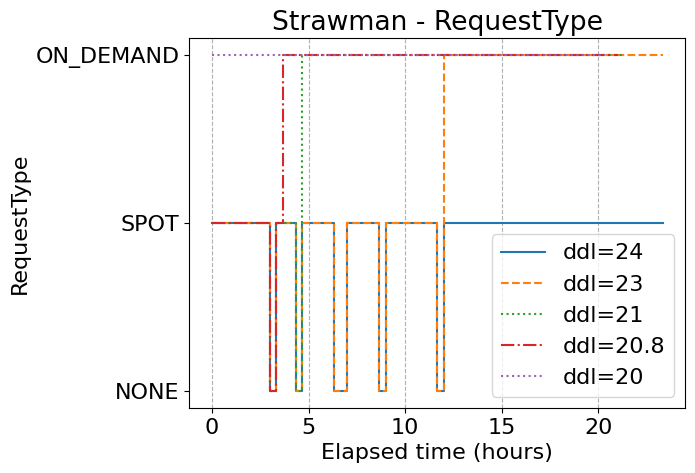

In [36]:
ax = plot_y(run_dfs, y_name='RequestType')
ax.set_xlabel('Elapsed time (hours)')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
ax.set_title(f'Strawman - RequestType')
ax.grid(True, which='major', axis='x', linestyle='--')

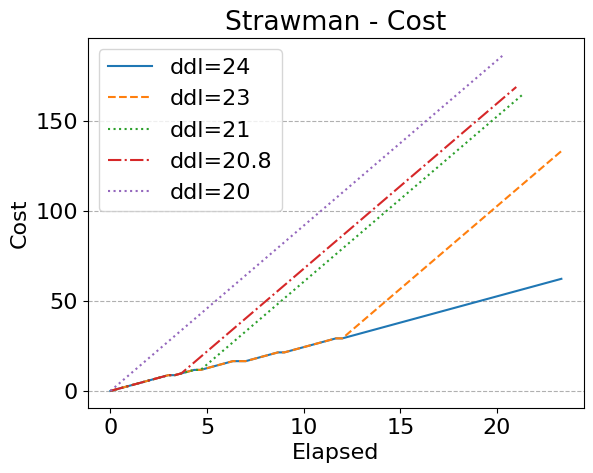

In [37]:
ax = plot_y(run_dfs, y_name='Cost', is_step_plot=False)
ax.set_title(f'Strawman - Cost')
ax.grid(True, which='major', axis='y', linestyle='--')

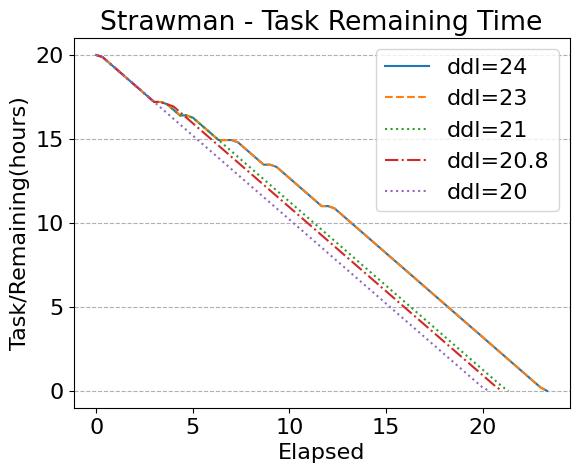

In [38]:
ax = plot_y(run_dfs, y_name='Task/Remaining(hours)', is_step_plot=False)
ax.set_title(f'Strawman - Task Remaining Time')
ax.grid(True, which='major', axis='y', linestyle='--')

## PairAmortizeStrategy

In [42]:
TAGS = []
DDLs = {24}
STRATEGIES = {'strawman', 'pair_amortize'}

run_dfs = filter_runs(TAGS, DDLs, STRATEGIES)
len(run_dfs)

2

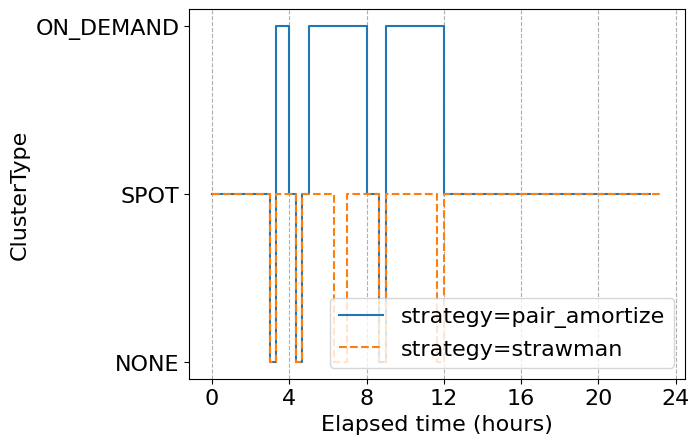

In [43]:
ax = plot_y(run_dfs, y_name='ClusterType', label_key=['strategy_metadata', 'name'], label_name='strategy')
ax.set_xlabel('Elapsed time (hours)')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels([ClusterType(i).name for i in [1, 2, 3]])
# ax.set_title(f'')
ax.set_xticks(list(range(0, 25, 4)))
ax.grid(True, which='major', axis='x', linestyle='--')

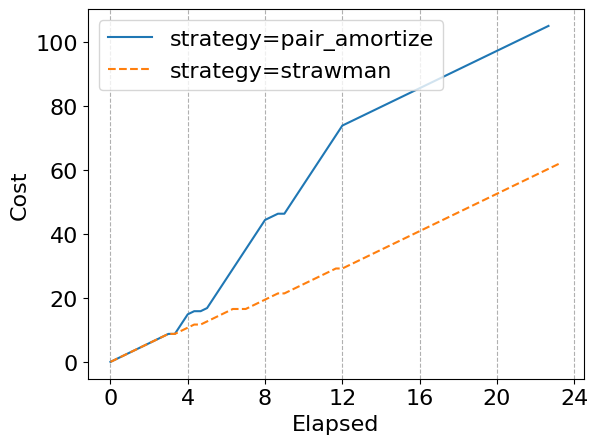

In [45]:
ax = plot_y(run_dfs, y_name='Cost', label_key=['strategy_metadata', 'name'], label_name='strategy', is_step_plot=False)
ax.set_xticks(list(range(0, 25, 4)))
ax.grid(True, which='major', axis='x', linestyle='--')

In [ ]:
ax = plot_y(run_dfs, y_name='Task/Remaining(hours)', label_key=['strategy_metadata', 'name'], label_name='strategy', is_step_plot=False)
ax.set_title(f'Task Remaining Time')
ax.grid(True, which='major', axis='y', linestyle='--')